In [34]:
%matplotlib inline

In [35]:
import numpy as np

import pprint
import time
import torch
import torchvision

import matplotlib.pyplot as plt
import torch.nn.functional as F

In [36]:
def show_image(data, class_list=None):
    image, label = data
    image = image.numpy().transpose((1, 2, 0))
        
    if class_list:
        label = class_list[label]
        
    plt.title(label)
    plt.imshow(image)

In [37]:
mnist = torchvision.datasets.MNIST(root='./data',
                                   transform=torchvision.transforms.ToTensor(),
                                   download=True,
                                   train=True)

If you recall, our breakdown of machine learning was:
- data
- model
- training.
And we are trying to cover the paper [Backpropagation Applied to Handwritten Zip Code Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf). 

We just covered data, so we'll move onto learning about the model.

A neural network model has several basic components:
- neural network layer;
- activation function;
- loss function.
We will cover all of these, beginning with the neural network layers.
But first, we'll have to make a short digression.

The original LeNet model took in a $16 \times 16$ image and its output was a 10 dimensional vector.
So, if we input an image of a 5 into the model:

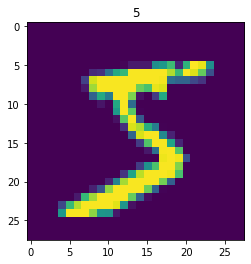

In [38]:
show_image(mnist[0])

Then the model should output a vector that is close to this one:
$$ [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] $$

The above vector is an example of one-hot encoding.
The idea is that if we have $C$ classes, then we want a $C$ dimensional vector that has $0$s in everything, except the class we want to predict. This will be a one.

To explain this more, suppose that we want to predict one of the four letters $A, B, C, D$.
Then we could one-hot encode it as:
$$ A \rightarrow [1, 0, 0, 0]$$
$$ B \rightarrow [0, 1, 0, 0]$$
$$ C \rightarrow [0, 0, 1, 0]$$
$$ D \rightarrow [0, 0, 0, 1]$$

We don't have to have this correspondence.
We could have another one, such as:
$$ D \rightarrow [1, 0, 0, 0]$$
$$ A \rightarrow [0, 1, 0, 0]$$
$$ C \rightarrow [0, 0, 1, 0]$$
$$ B \rightarrow [0, 0, 0, 1]$$

The imporant thing is that once we decide on this correspondence it needs to be fixed.
One data structure that can help with this is the `dict` class:

In [41]:
class_dict = {'A': np.array([1, 0, 0, 0]),
              'B': np.array([0, 1, 0, 0]),
              'C': np.array([0, 0, 1, 0]),
              'D': np.array([0, 0, 0, 1])}

class_dict

{'A': array([1, 0, 0, 0]),
 'B': array([0, 1, 0, 0]),
 'C': array([0, 0, 1, 0]),
 'D': array([0, 0, 0, 1])}

How would we make this into a function?
We want to take in classes and output a correspondence between the classes and the one-hot encoding.

- What do you think a good name would be?
- What should the inputs be?
- What should the ouptuts be?

We're going to work on this question together right now.

def one_hot():
    pass

Or the too clever way:

In [48]:
def one_hot(classes):
    num_classes = len(classes)
    ident = np.eye(num_classes)

    class_dict = {classes[i]: ident[i] for i in range(num_classes)}

    return class_dict

In [49]:
one_hot(['A', 'B', 'C', 'D'])

{'A': array([1., 0., 0., 0.]),
 'B': array([0., 1., 0., 0.]),
 'C': array([0., 0., 1., 0.]),
 'D': array([0., 0., 0., 1.])}

Back to the model.

We want the LeNet model to output a 10-dimensional vector, because there are 10 classes we want to predict: the 10 digits.
We'll go into more detail about this later when we talk about loss functions and training.

The first thing we input into our model is an image converted to an $28 \times 28$ array of numbers!
This is sometimes called the **input layer**.

After we input the image, the next layer is called a **convolutional layer**.
The convolutional layer as a neural network layer was developed by Kunihiko Fukushima.
He developed it for his neural network based handwriting recognition model called the **neocognitron**.
The convolutional layer consists of several convolutional kernels that operate on the image.
Let's go through an example.
We'll take a $3 \times 3$ kernel and have it operate on a $5 \times 5$ image.

Our $3 \times 3$ kernel will be:
$$
\begin{pmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{pmatrix}
$$
and we'll work on the $5 \times 5$ matrix:
$$
\begin{pmatrix}
4 & 4 & 2 & 4 & 4 \\
5 & 3 & 4 & 0 & 3 \\
1 & 0 & 2 & 3 & 0 \\
5 & 4 & 2 & 4 & 5 \\
0 & 0 & 4 & 3 & 2 \\
\end{pmatrix}
$$

The $3 \times 3$ kernel is one of the Prewitt operator, used for edge detection.
Did you notice something about what happened to the size of the $5 \times 5$ matrix after we did a convolution on it with $3 \times 3$ kernel?
The height and width both dropped by 2.

If we used
$$
\begin{pmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{pmatrix}
$$
and
$$
\begin{pmatrix}
-1 & -1 & -1 \\
 0 &  0 &  0 \\
 1 &  1 &  1 \\
\end{pmatrix}
$$
as our convolutional kernels and we put in a $1 \times 28 \times 28$ MNIST image, we would get out a $2 \times 26 \times 26$ tensor.
If we wanted to keep the same height and width, 28, then we can do something called padding.
Padding is just adding different values to the edge of our input.

Pytorch has a couple ways to do this padding operation, but the primary way we'll deal with it is as a parameter in our convolutional layer.

In [72]:
image, _ = mnist[0]

# We choose 1. as the value below, because it's easier to see in the image that we padded it.
padded_image = F.pad(image, pad=(1, 1, 1, 1), value=1.)
padded_image.shape

torch.Size([1, 30, 30])

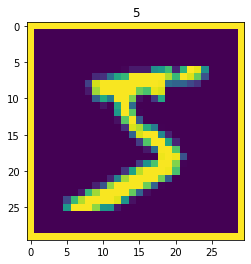

In [73]:
show_image((padded_image, 5))

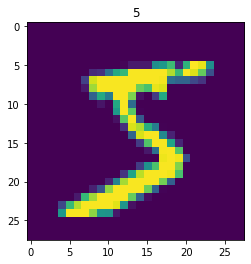

In [67]:
show_image(mnist[0])

Let's look closer at our the convolutional layer in Pytorch

`torch.nn.Conv2d(in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 bias)`
                 
Let's go through some of the parameters:
- `in_channels`: this is the number of channels in our input. So, if we input a (3, 224, 224) tensor, we would set the value of this to 3.
- `out_channels`: this is the number of channels we want to ouptut. If we want to have 6 channels out, we would set this to 6.
- `kernel_size`: this is the size of the kernel; above we had a $3 \times 3$ kernel, so this would be set to 3.
- `stride`: this is how many element to skip over; above we had a stride of 1.
- `padding`: we talked about this above.
- `bias`: this would be a tensor the same shape as our output; this would be added to the output before its sent to the next layer.

Let's look at an example!

In [85]:
conv_layer = torch.nn.Conv2d(1, 6, 3, stride=1, padding=1, bias=False)

In [87]:
conv_layer(image).shape

torch.Size([6, 28, 28])

So, we have the first layer down.
The next layer is what is called a pooling layer.
There are typically two types of these layers: max pooling and average pooling.
The purpose of these is to reduce the input size to the next layer in order to reduce the parameter size of the next layer.

Let's talk about both max pooling and average pooling.
For max pooling, our kernel just chooses the largest element in the kernel.
With these operations, you should think of the kernel as a sliding window.
Let's look at an example of this.
We'll look at a $2\times 2$ and $3 \times 3$ kernel on the matrix:
$$
\begin{pmatrix}
4 & 4 & 2 & 4 & 4 \\
5 & 3 & 4 & 0 & 3 \\
1 & 0 & 2 & 3 & 0 \\
5 & 4 & 2 & 4 & 5 \\
0 & 0 & 4 & 3 & 2 \\
\end{pmatrix}
$$

If we perform max pooling with a $2 \times 2$ kernel, we get:
$$
\begin{pmatrix}
5 & 4 & 4 & 4 \\
5 & 4 & 4 & 3 \\
5 & 4 & 4 & 5 \\
5 & 4 & 4 & 5
\end{pmatrix}
$$
and with a $3 \times 3$ kernel, we get:
$$
\begin{pmatrix}
5 & 4 & 4 \\
5 & 4 & 4 \\
5 & 4 & 5
\end{pmatrix}
$$

I know this is tedious.
This is why we invented and used computers!
Now, let's look at the average pooling case on the same matrix.
With a $2 \times 2$ kernel we get:
$$
\begin{pmatrix}
   4 & 3.25 & 2.5  & 2.75 \\
2.25 & 2.75 & 2.25 & 1.5  \\
2.5  & 2    & 2.75 & 3    \\
2.25 & 2.5  & 3.25 & 3.5
\end{pmatrix}
$$
with a $3 \times 3$ kernel we get:
$$
\begin{pmatrix}
2.7778 & 2.4444 & 2.4444 \\
2.8889 & 2.4444 & 2.5556 \\
2.0000 & 2.4444 & 2.7778
\end{pmatrix}
$$

In [109]:
x = torch.tensor([[
    [4, 4, 2, 4, 4],
    [5, 3, 4, 0, 3],
    [1, 0, 2, 3, 0],
    [5, 4, 2, 4, 5],
    [0, 0, 4, 3, 2]
]], dtype=torch.float)

In [110]:
torch.nn.AvgPool2d(kernel_size=(3, 3), stride=1)(x)

tensor([[[2.7778, 2.4444, 2.4444],
         [2.8889, 2.4444, 2.5556],
         [2.0000, 2.4444, 2.7778]]])

That was much easier to calculate, right?

For our model, we're going to use the average pooling layer.
Let's look at the Pytorch layer:
`torch.nn.AvgPool2d(kernel_size,
                    stride,
                    padding)`

- `kernel_size`: this is just the size of our sliding window.
- `stride`: this is exactly the same as in the `torch.nn.Conv2d` case; it just tells us how many steps to take.
- `padding`: this is exactly the same as in the `torch.nn.Conv2d` case; again, it tells us how many zeroes to pad our tensor with; this allows us to control the size of the output.

`torch.nn.AvgPool2d` can be written as a kernel, let's spend a few minutes trying to figure out out how!

In [127]:
weight = 1 / 9 * torch.ones((1, 1, 3, 3))

In [128]:
F.conv2d(x, weight=weight, stride=1)

tensor([[[2.7778, 2.4444, 2.4444],
         [2.8889, 2.4444, 2.5556],
         [2.0000, 2.4444, 2.7778]]])

Since we want a specific layer, we called `F.conv2d` as opposed to `torch.nn.Conv2d`.
As you see, we can do a convolution to get the same result as average pooling!

The next layer is another convolutional layer.
What we're going to do is not exactly what was done in the LeNet paper, but it's a close enough approximation.
The next layer is

`torch.nn.Conv2d(in_channels=6,
                 out_channels=16,
                 kernel_size=5,
                 stride=1,
                 padding=0)`
                 
We should note that we can omit putting in `padding=0` and `stride=1`, because they are both default values.

This convolutional layer is immediately followed by the same type of pooling layer as before:

`torch.nn.AvgPool2d(kernel_size=2,
                    stride=2,
                    padding=0)`
                    
As before, we can omit `padding=0`, because it is a default value.

If we input a tensor of shape (1, 28, 28), that represents a black and white image, then the output at this point is a tensor of shape (16, 5, 5).

We want to input this into what is called a **linear** layer or a **fully connected** layer.
The input to this layer has to be a tensor of shape $(m, )$, also known as an $m$-dimensional vector.
We need an $(n, m)$ matrix that we denote by $\textbf{W}$.
With neural networks, this is called a **weight** matrix.
We also have an optional parameter called the **bias**.
This is a vector of shame $(n, )$, because it's added after the multiplication.
Remember that the output of an $(n, m)$ matrix multiplied by a $(m, )$ vector is a $(n, )$ vector.

The problem we have is our tensor is the wrong shape, if we try to input it into the linear layer, we'll get a shape error.
What we need to do is change the shape of this tensor somehow.
What shape should it have if we change it?

The function we want is available within Pytorch and it's called `torch.flatten`.

In [129]:
x = torch.randn(3, 4, 5)

In [134]:
torch.flatten(x).shape

torch.Size([60])

As we saw, our input was a tensor of shape (3, 4, 5) and it's output was a tensor of shape (60,).
What is $3 \times 4 \times 5$?

`torch.flatten` has three parameters:
- `input`: this is just the tensor that we want to flatten.
- `start_dim`: this is the start of the dimension we want to flatten.
- `end_dim`: this is the end of the dimensions we want to flatten.

If we don't input anything for `start_dim` and `end_dim`, they default to flattening everything.

Let's look at another example:

In [136]:
x = torch.randn(3, 4, 5, 6, 7, 8)

If we call

`torch.flatten(x, start_dim=1, end_dim=3)`

then what will the shame of $x$ be?
Let's take a minute to guess before we input it into the next cell

In [ ]:
torch.flatten(x, start_dim=1, end_dim=3).shape

Back to our LeNet model.
We want to flatten everything in our (16, 5, 5)-tensor.
This gives us a tensor of shape (400, ).

Recall that we talked about the stride of a tensor last Friday.
So, `torch.flatten` works by changing the stride of the tensor!

So, we have a (400, )-tensor going into our fully connnected layer.
For the paper, they wanted an (84, )-tensor as output.
The way we would create this layer is

`torch.nn.Linear(400, 84)`

This is a simpler layer than other ones.
We only have three parameters for it:

`torch.nn.Linear(in_features, out_features, bias)`

- `in_features`: This is the size of the tensor/vector coming in.
- `out_features`: This is what size we want to the tensor/vector to come out as.
- `bias`: If we want to add a vector to it at the end, we would include this one.

The default of `bias` is `True`, so we typically don't include it.

So, we have an (84, )-tensor as our input now and at this point we want to make a prediction.
We have 10 classes, so we want 10 outputs.
So, our last layer is

`torch.nn.Linear(84, 10)`.

We said there were some basic components to neural networks:
- neural network layer;
- activation function;
- loss function.

We only covered neural network layer so far.
We're going to cover activation function next.

Because of the way matrix multiplication works if we have two layers and no activation function between, it's the same as just having one neural network layer.
This is why we need an activation function.
The activation function that the LeNet model used was what's called a **hyperbolic tangent** function.
This function is defined as
$$
\operatorname{tanh}(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} = \frac{e^{2x} - 1}{e^{2x} + 1}
$$
and here is a picture of it:

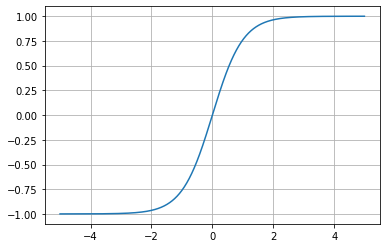

In [139]:
x = np.arange(-5.0, 5.0, 0.01)
y = np.tanh(x)

fig, ax = plt.subplots()
ax.plot(x, y)

ax.grid()
plt.show()

Activation functions act on tensors point-wise.
So, if we have
$$
\textbf{X} = 
\begin{pmatrix}
1 & 3 & 4 \\
-4 & 0 & -1 \\
\end{pmatrix}
$$
the ouput of $\operatorname{tanh}(\textbf{X})$ is 
$$
\operatorname{tanh}(\textbf{X}) =
\begin{pmatrix}
\operatorname{tanh}(1)  & \operatorname{tanh}(3) & \operatorname{tanh}(4) \\
\operatorname{tanh}(-4) & \operatorname{tanh}(0) & \operatorname{tanh}(-1) \\
\end{pmatrix}
$$

So, we put `torch.tanh` between each layer.

Finally, we need to cover the loss function.
In the LeNet paper, they used what is called **mean squared error**.
Suppose that
$$
\widehat{\textbf{y}} = (\widehat{y_{1}}, \ldots, \widehat{y_{n}})
$$
is our prediction and
$$
\textbf{y} = (y_{1}, \ldots, y_{n})
$$
is our label, then the mean squared error is defined as
$$
\operatorname{MSE}(\widehat{\textbf{y}}, \textbf{y}) =
\sqrt{(y_{1} - \widehat{y}_{1})^{2} + \cdots + (y_{n} - \widehat{y}_{n})^{2}}
$$

Let's take a minute to see if we can implement this!

In [140]:
def MSE(pred, label):
    raise NotImplementedError

I will warn you that this isn't the best loss function to use for our purposes.
The reason we're using it here is because it was used in the original LeNet paper.
We will go over a better one later.

Now we have to put it all together!
There are several ways to do this, but we'll primarily be doing the `class` based method.

All of our models will be subclasses of the `torch.nn.Module` class.
I'll create a single layer neural network model to show how it works:

In [187]:
class FirstModel(torch.nn.Module):
    
    def __init__(self, input_size=28 * 28, num_classes=10):
        super().__init__()
        self.lin_layer = torch.nn.Linear(input_size, num_classes)
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.lin_layer(x)
        return torch.nn.LogSoftmax(dim=-1)(x)

In [188]:
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=torch.tensor([0.1307]), std=torch.tensor([0.3081]))
    ])

In [189]:
train_ds = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transforms)

test_ds = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transforms)

In [190]:
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=len(train_ds),
                                       shuffle=True,
                                       num_workers=4)
test_dl = torch.utils.data.DataLoader(test_ds,
                                      batch_size=len(test_ds),
                                      shuffle=False,
                                      num_workers=4)

In [191]:
model = FirstModel()
criterion = torch.nn.NLLLoss()
opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [192]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

FirstModel(
  (lin_layer): Linear(in_features=784, out_features=10, bias=True)
)

In [193]:
for epoch in range(23):
    for inputs, label in train_dl:
        inputs, label = inputs.to(device), label.to(device)
        
        opt.zero_grad(set_to_none=True)
        out = model(inputs)
        loss = criterion(out, label)
        loss.backward()
        opt.step()
    print(f"Finished epoch {epoch + 1}.")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 1 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 2 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 3 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 4 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 5 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 6 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 7 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 8 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 9 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 10 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 11 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 12 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 13 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 14 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 15 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 16 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 17 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 18 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 19 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 20 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 21 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 22 epoch.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f98ee5f0b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Finished 23 epoch.


In [194]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
    print(f'Accuracy of the network on 10000 test images: {100 * correct // total} %')
    return 100 * correct // total

In [195]:
evaluate(model, test_dl)

Accuracy of the network on 10000 test images: 67 %


67

Now, you're going to implement the LeNet model yourself!
We'll have the boiler plate, but you'll have to implement `__init__` and `__forward__` methods yourself.
I will put the information about the layers here

- Convolutional layer
    - in channels: 1
    - out channels: 6
    - kernel size: 5
    - padding: 2
- Average Pooling
    - kernel size: 2
    - stride: 2
- Convolutional Layer
    - in channels: 6
    - out channels: 16
    - kernel size: 5
- Average Pooling
    - kernel size: 2
    - stride: 2
- Flatten
- Linear Layer
    - in features: 400
    - out features: 120
- Linear Layer
    - in features: 120
    - out features: 84
- Linear Layer
    - in features: 84
    - out features: 10
- Activation: `torch.tanh`

In [197]:
class LeNet(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        raise NotImplementedError
        
    def forward(self, x):
        raise NotImplementedError

In [198]:
def train(model, train_dl, test_dl, epochs=23, evaluate=True):
    criterion = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for epoch in range(epochs):
        for inputs, label in train_dl:
            inputs, label = inputs.to(device), label.to(device)

            opt.zero_grad(set_to_none=True)
            out = model(inputs)
            loss = criterion(out, label)
            loss.backward()
            opt.step()
        print(f"Finished epoch {epoch + 1}.")
    print(f"Finished Training!")
    if evaluate:
        print("Evaluating")
        evaluate(model, test_dl)

NotImplementedError: 

In [199]:
model = LeNet()

NotImplementedError: 

In [ ]:
train(model, train_dl, test_dl)